In [6]:
import lib.functions0 as f0
import numpy as np
from scipy.linalg import expm
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
from sympy import Matrix
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ibmqfactory.load_account:WARNING:2022-04-08 16:09:38,809: Credentials are already in use. The existing account in the session will be replaced.


## IBM open-science-prize-2021/22 solution. By Quantum Polo Gang: Ruben, Fabio & Valerio

## Decomposition:
- We computed numerically the operator of N trotter steps, for a certain evolution time: $U^n$
- Observing that this operator preserves the magnetization of the system, if the initial state belongs to an eigenspace of the magnetization is possible to decompose the operator with 4 c-not. If the initial state is a superposition of states with different magnetization the best decomposition we found has 11 c-not (14 for the Jakarta geometry).
- Our initial state is $|110>$ (qubits 5,3 and 1 respectively) so we can use the best decomposition (4 c-not).

To see the decomposition procedure open  *decomposition.ipynb* file.

Let's start from the defining of the evolution circuit parameters:

- *steps*: number of trotter steps (integer).
- *time*: time of evolution (float).
- *initial_state*: the 3-qubit initial state (string): from right to left, associated with qubits 1, 3 and 5 respectively
- *shots*: number of shots for every run.
- *backend*: here you can choose on which backend run the simulation: *backend_sim_jakarta* (noisy simulator), *backend_real_jakarta* (real device), *backend_sim* (simulator)

In [7]:
n_steps=99
time=np.pi
initial_state={"110": 1}
shots = 80
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                    0,                    0,                    0,                    0,                    0,                    0,   0],
[  0,      1.0 + 0.00105*I, 0.000102 + 0.00105*I,                    0, -9.87e-5 - 0.00211*I,                    0,                    0,   0],
[  0, -9.87e-5 + 0.00105*I,      1.0 - 0.00211*I,                    0, 0.000102 + 0.00105*I,                    0,                    0,   0],
[  0,                    0,                    0,      1.0 + 0.00105*I,                    0, -9.87e-5 + 0.00105*I, 0.000102 - 0.00211*I,   0],
[  0, 0.000102 - 0.00211*I, -9.87e-5 + 0.00105*I,                    0,      1.0 + 0.00105*I,                    0,                    0,   0],
[  0,                    0,                    0, 0.000102 + 0.00105*I,                    0,      1.0 - 0.00211*I, -9.87e-5 + 0.00105*I,   0],
[  0,                    0,                    0, -9.87e-5 - 0.00211*I,                    0, 0.000102 + 0.00105*I,      1.0 + 

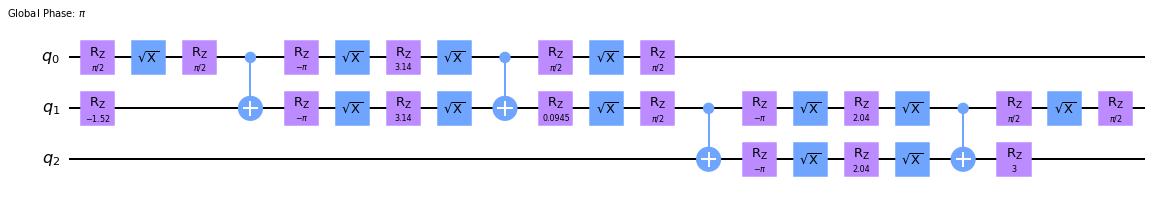

In [24]:
phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = f0.get_gates_parameters(trotterized, initial_state={"110": 1.0})

# Assembles the parametric 2-qubit circuits
M1_qc = f0.fixed_magnetization_two_qubit_gate(phase_1_1,phase_1_2,a1)
M2_qc = f0.fixed_magnetization_two_qubit_gate(phase_2_1,phase_2_2,a2)

evol_qr = QuantumRegister(3 ,name="q")
evol_qc = QuantumCircuit(evol_qr, name="U")

evol_qc.append(M1_qc, [evol_qr[0],evol_qr[1]])
evol_qc.append(M2_qc, [evol_qr[1],evol_qr[2]])

evol_qc = transpile(evol_qc, basis_gates=["cx","rz","x","sx"])
evol_qc.draw(output="mpl")

In [10]:
from qiskit import quantum_info
Matrix(quantum_info.Operator(evol_qc)).n(2, chop=True)

Matrix([
[1.0 - 0.0011*I,              0,                0,                0,                 0,                 0,              0,              0],
[             0, 1.0 - 0.0011*I,         0.0024*I,                0,                 0,                 0,              0,              0],
[             0,      -0.0011*I,  -0.44 - 0.064*I,                0, -0.89 + 0.00094*I,                 0,              0,              0],
[             0,              0,                0,  -0.44 - 0.064*I,                 0, -0.89 + 0.00094*I,      -0.0021*I,              0],
[             0,       0.0021*I, 0.89 + 0.00094*I,                0,   -0.44 + 0.064*I,                 0,              0,              0],
[             0,              0,                0, 0.89 + 0.00094*I,                 0,   -0.44 + 0.064*I,      -0.0011*I,              0],
[             0,              0,                0,                0,                 0,          0.0024*I, 1.0 + 0.0011*I,              0],
[          

Then we add the copy check for the mitigation (see *Ancillas_Error_mitigation_Git_Hub.pynb*)

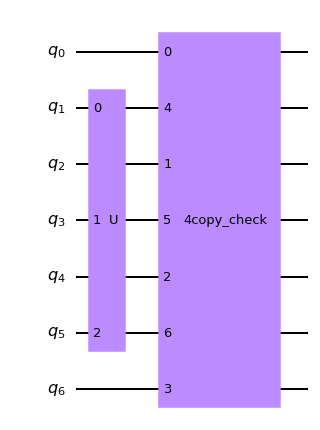

In [11]:
complete_qr = QuantumRegister(7, name="q")
complete_qc = QuantumCircuit(complete_qr)
complete_qc.append(evol_qc, [complete_qr[1], complete_qr[3], complete_qr[5]] )

complete_qc = f0.add_symmetry_check(complete_qc, 
                            [complete_qr[1],complete_qr[3],complete_qr[5]], 
                            [complete_qr[0],complete_qr[2],complete_qr[4],complete_qr[6]], 
                            type="4copy_check")
complete_qc.draw(output="mpl")

Then, we build the tomography circuits

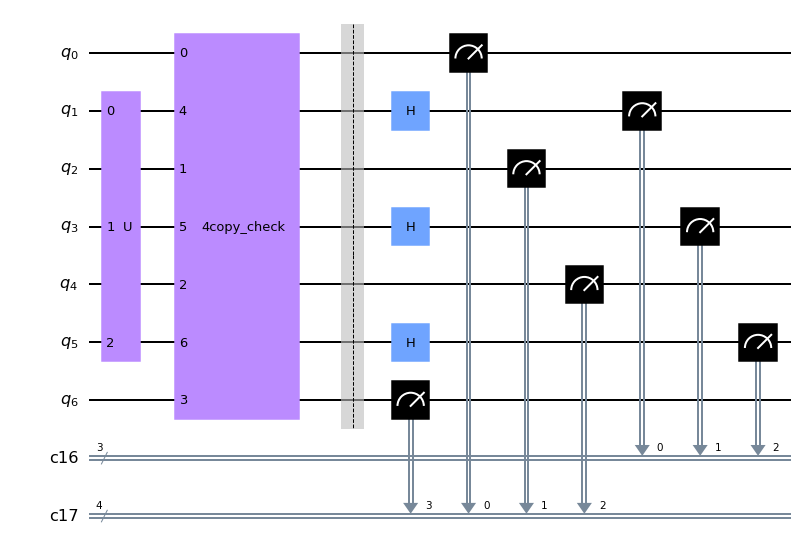

In [12]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

qcs = state_tomography_circuits(complete_qc, 
                                [complete_qr[1],complete_qr[3],complete_qr[5]])

for qc in qcs:
    cr_anc = ClassicalRegister(4)
    qc.add_register(cr_anc)
    #qc.barrier()
    qc.measure([0,2,4,6],cr_anc)

qcs[0].draw(output="mpl")

To see the improvements we measure the raw simulation without ancillas

In [13]:
extended_evol_qr = QuantumRegister(7, name="q")
extended_evol_qc = QuantumCircuit(extended_evol_qr)
# Places the 3-qubit evolution circuit on a Jakarta register 
extended_evol_qc.append(evol_qc, 
                        [extended_evol_qr[1], extended_evol_qr[3], extended_evol_qr[5]])
qcs_na = state_tomography_circuits( extended_evol_qc, 
                                    [extended_evol_qr[1], extended_evol_qr[3], extended_evol_qr[5]])
qcs_na[0].draw()

░               
  q_0: ───────░───────────────
       ┌────┐ ░ ┌───┐┌─┐      
  q_1: ┤0   ├─░─┤ H ├┤M├──────
       │    │ ░ └───┘└╥┘      
  q_2: ┤    ├─░───────╫───────
       │    │ ░ ┌───┐ ║ ┌─┐   
  q_3: ┤1 U ├─░─┤ H ├─╫─┤M├───
       │    │ ░ └───┘ ║ └╥┘   
  q_4: ┤    ├─░───────╫──╫────
       │    │ ░ ┌───┐ ║  ║ ┌─┐
  q_5: ┤2   ├─░─┤ H ├─╫──╫─┤M├
       └────┘ ░ └───┘ ║  ║ └╥┘
  q_6: ───────░───────╫──╫──╫─
              ░       ║  ║  ║ 
c44: 3/═══════════════╩══╩══╩═
                      0  1  2

Building the calibration circuits

In [20]:
qcs_calibs, meas_calibs = f0.build_calibration_circuits_for_all_base_elements("column_evolution_remake", 
                                                q_anc=[0,2,4,6], 
                                                check="yes", 
                                                check_type="4copy_check")
state_lables = f0.bin_list(7)

In [17]:
state_lables[0]

'0000000'

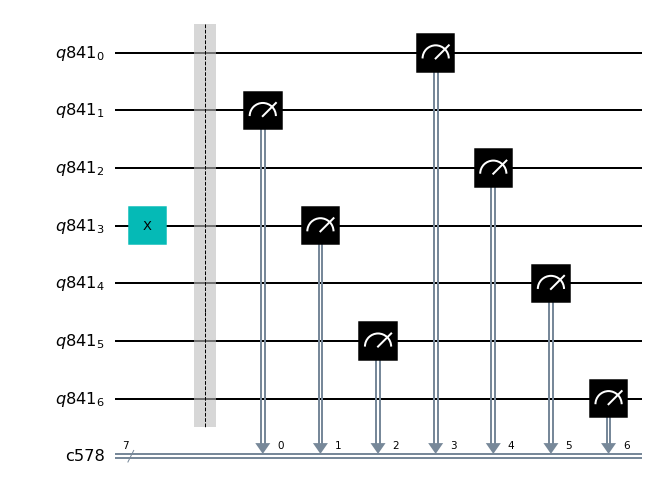

In [21]:
meas_calibs[2].draw(output="mpl")

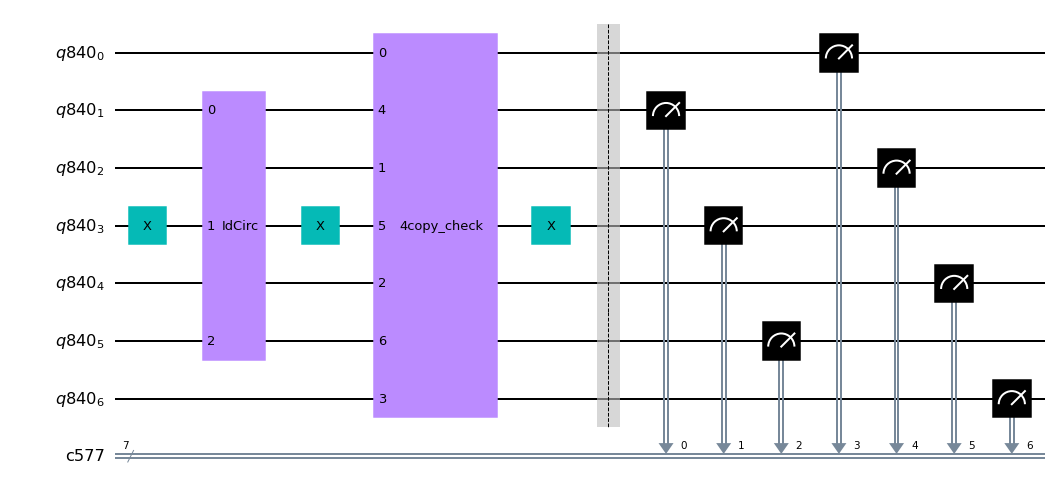

In [22]:
qcs_calibs[2].draw(output="mpl")

Than we run all the circuits

In [23]:
jobs_evo=execute(qcs_tot, backend=backend, shots=shots)
job_cal_our=execute(qcs_calibs, backend=backend, shots=shots)
job_cal=execute(meas_calibs, backend=backend, shots=shots)

NameError: name 'qcs_tot' is not defined

In [ ]:
jobs_evo_result = jobs_result(job_evolution = jobs_evo, reps = reps, ancillas=[0,2,4,6])

or we can retrieve the jobs

In [ ]:
#evo_ID = "6233ae39d97bff04d66929e9"
#cal_ID = "6233ae3ba2f72dff43da994f"

#evo_job=backend.retrieve_job(evo_ID)
#job_cal_our=backend.retrieve_job(cal_ID)
'''
reps=8
steps=42
backend=backend_real_jakarta

job_cal_our =backend.retrieve_job("6237aee18293e9eb4e1e4c4a")
job_cal =backend.retrieve_job("6237aedf0af65dc88cd92302")

job=backend.jobs(limit=30, start_datetime= "2022-03-19", end_datetime="2022-03-26")[2]

jobs_evo_result = jobs_result(job_evolution = job, reps = reps, ancillas=[0,2,4,6])
'''

In [ ]:
#### DA CANCELLAREEEEEEEEEEEEEEEEEEE
#state_lables = bin_list(7)
#qcs_na = circuits_without_ancillas_measuraments(job)


Next we apply the mitigation in the following way:

- measure mitigation: we apply the inverse of the calibration matrix to each circuit (see *measure_mitigation.ipynb*)
- ancillas mitigation: we throw away all the measures which contain a value for the ancillas physically forbidden.

this is done by the *mitigate* function.

Then we compute the fidelity for both the mitigated results and not-mitigated ones, in order check the gain given by the mitigation.

In [ ]:
meas_fitter_our = CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels=state_lables)


target_state = (One^One^Zero).to_matrix()

fids=np.zeros([reps,4])
fids_mean=np.zeros(4)
fids_dev=np.zeros(4)

for j in range(reps):
    
    res = jobs_evo_result[j]
    print(j)
    new_res, new_res_nm = mitigate(res, Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
    new_res_our, new_res_nm = mitigate(res, Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_our)
    new_res_not_mitigated = mitigate(res, Measure_Mitig="no", ancillas_conditions=bin_list(4))

    fids[j,0] = fidelity_count(new_res_not_mitigated, qcs_na, target_state)
    fids[j,1] = fidelity_count(new_res_nm, qcs_na, target_state)
    fids[j,2] = fidelity_count(new_res, qcs_na, target_state)
    fids[j,3] = fidelity_count(new_res_our, qcs_na, target_state)

for i in range(4):
    fids_mean[i]=np.mean(fids[:,i])
    fids_dev[i]=np.std(fids[:,i])


In [ ]:
new_res_our.get_counts(-1)

Printing the fidelity

In [ ]:
labels = ["raw:                                       ",
          "ancillas mitigation:                       ",
          "ancillas and qiskit measurement mitigation:",
          "ancillas and our measurement mitigation:   "
]

for i in range(4):
    print(labels[i], fids_mean[i], " +- ", fids_dev[i])